# Animated HRRR 

Forked from https://gist.github.com/scollis/1bfc16a68b855a8166aae156fa394f03




In [1]:
import xarray as xr
import numpy as np
import fsspec
import datetime as dt

from matplotlib import pyplot as plt

import cartopy.crs as ccrs
import cartopy.feature as cfeature

from cartopy.feature import NaturalEarthFeature
from xmovie import Movie
#DANGER
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

#### Create Local Dask Cluster 
Local cluster

In [2]:
from dask.distributed import Client
client = Client()  # set up local cluster on your laptop
client

2022-07-14 15:06:10,815 - distributed.diskutils - INFO - Found stale lock file and directory '/var/folders/f4/f3jp1t2x0hddhf4vz50gzlnc0000gn/T/dask-worker-space/worker-58r8he1k', purging
2022-07-14 15:06:10,816 - distributed.diskutils - INFO - Found stale lock file and directory '/var/folders/f4/f3jp1t2x0hddhf4vz50gzlnc0000gn/T/dask-worker-space/worker-3iinz97p', purging
2022-07-14 15:06:10,816 - distributed.diskutils - INFO - Found stale lock file and directory '/var/folders/f4/f3jp1t2x0hddhf4vz50gzlnc0000gn/T/dask-worker-space/worker-gkptt14j', purging
2022-07-14 15:06:10,817 - distributed.diskutils - INFO - Found stale lock file and directory '/var/folders/f4/f3jp1t2x0hddhf4vz50gzlnc0000gn/T/dask-worker-space/worker-7p3ct4mq', purging


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 16,Total memory: 64.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:50950,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 16
Started: Just now,Total memory: 64.00 GiB
Comm: tcp://127.0.0.1:50966,Total threads: 4
Dashboard: http://127.0.0.1:50967/status,Memory: 16.00 GiB
Nanny: tcp://127.0.0.1:50953,


In [3]:
rpath = 's3://esip-qhub-public/noaa/hrrr/hrrr_best.json'

r_opts = {'anon':True}
s_opts = {'anon':True, 'skip_instance_cache':True}

fs = fsspec.filesystem("reference", fo=rpath, ref_storage_args=s_opts,
                       remote_protocol='s3', remote_options=r_opts)


In [4]:
fs.ls('')

[{'name': '.zgroup', 'type': 'file', 'size': 17},
 {'name': 'valid_time', 'type': 'directory', 'size': 0},
 {'name': '.zattrs', 'type': 'file', 'size': 422},
 {'name': 'heightAboveGround', 'type': 'directory', 'size': 0},
 {'name': 'time', 'type': 'directory', 'size': 0},
 {'name': 'step', 'type': 'directory', 'size': 0},
 {'name': 'latitude', 'type': 'directory', 'size': 0},
 {'name': 'longitude', 'type': 'directory', 'size': 0},
 {'name': 't2m', 'type': 'directory', 'size': 0},
 {'name': 'pt', 'type': 'directory', 'size': 0},
 {'name': 'sh2', 'type': 'directory', 'size': 0},
 {'name': 'd2m', 'type': 'directory', 'size': 0},
 {'name': 'r2', 'type': 'directory', 'size': 0},
 {'name': 'u10', 'type': 'directory', 'size': 0},
 {'name': 'v10', 'type': 'directory', 'size': 0},
 {'name': 'si10', 'type': 'directory', 'size': 0},
 {'name': 'unknown', 'type': 'directory', 'size': 0}]

In [5]:
m = fs.get_mapper("")

ds = xr.open_dataset(m, engine="zarr", backend_kwargs=dict(consolidated=False), 
                      chunks={'valid_time':1})

In [6]:
ds

<xarray.Dataset>
Dimensions:            (valid_time: 30, y: 1059, x: 1799)
Coordinates:
    heightAboveGround  float64 ...
    latitude           (y, x) float64 dask.array<chunksize=(1059, 1799), meta=np.ndarray>
    longitude          (y, x) float64 dask.array<chunksize=(1059, 1799), meta=np.ndarray>
    step               timedelta64[ns] ...
    time               (valid_time) datetime64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
  * valid_time         (valid_time) datetime64[ns] 2022-07-11T18:00:00 ... 20...
Dimensions without coordinates: y, x
Data variables:
    d2m                (valid_time, y, x) float32 dask.array<chunksize=(1, 1059, 1799), meta=np.ndarray>
    pt                 (valid_time, y, x) float32 dask.array<chunksize=(1, 1059, 1799), meta=np.ndarray>
    r2                 (valid_time, y, x) float32 dask.array<chunksize=(1, 1059, 1799), meta=np.ndarray>
    sh2                (valid_time, y, x) float32 dask.array<chunksize=(1, 1059, 1799), meta=np.ndarray>
    si10               (valid_time, y, x) float32 dask.array<chunksize=(1, 1059, 1799), meta=np.ndarray>
    t2m                (valid_time, y, x) float32 dask.array<chunksize=(1, 1059, 1799), meta=np.ndarray>
    u10                (valid_time, y, x) float32 dask.array<chunksize=(1, 1059, 1799), meta=np.ndarray>
    unknown            (valid_time, y, x) float32 dask.array<chunksize=(1, 1059, 1799), meta=np.ndarray>
    v10                (valid_time, y, x) float32 dask.array<chunksize=(1, 1059, 1799), meta=np.ndarray>
Attributes:
    Conventions:             CF-1.7
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_edition:            2
    GRIB_subCentre:          0
    history:                 2022-07-14T18:39 GRIB to CDM+CF via cfgrib-0.9.1...
    institution:             US National Weather Service - NCEP

In [7]:
ds = ds.assign_coords(longitude=(((ds.longitude + 180) % 360) - 180))
ds = ds.assign_coords({'longitude': ds['longitude'],
                       'latitude': ds['latitude']})

In [8]:
var = 't2m'  # Temperature at 2m height

In [9]:
ds.valid_time

<xarray.DataArray 'valid_time' (valid_time: 30)>
array(['2022-07-11T18:00:00.000000000', '2022-07-11T20:00:00.000000000',
       '2022-07-11T23:00:00.000000000', '2022-07-12T00:00:00.000000000',
       '2022-07-12T08:00:00.000000000', '2022-07-12T11:00:00.000000000',
       '2022-07-12T12:00:00.000000000', '2022-07-12T13:00:00.000000000',
       '2022-07-12T14:00:00.000000000', '2022-07-12T16:00:00.000000000',
       '2022-07-12T17:00:00.000000000', '2022-07-12T18:00:00.000000000',
       '2022-07-12T20:00:00.000000000', '2022-07-13T02:00:00.000000000',
       '2022-07-13T03:00:00.000000000', '2022-07-13T05:00:00.000000000',
       '2022-07-13T10:00:00.000000000', '2022-07-13T11:00:00.000000000',
       '2022-07-13T20:00:00.000000000', '2022-07-13T21:00:00.000000000',
       '2022-07-13T22:00:00.000000000', '2022-07-14T01:00:00.000000000',
       '2022-07-14T02:00:00.000000000', '2022-07-14T04:00:00.000000000',
       '2022-07-14T12:00:00.000000000', '2022-07-14T13:00:00.000000000',
       '2022-07-14T15:00:00.000000000', '2022-07-14T16:00:00.000000000',
       '2022-07-15T00:00:00.000000000', '2022-07-15T09:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
    heightAboveGround  float64 2.0
    step               timedelta64[ns] 01:00:00
    time               (valid_time) datetime64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
  * valid_time         (valid_time) datetime64[ns] 2022-07-11T18:00:00 ... 20...
Attributes:
    long_name:      time
    standard_name:  time

In [10]:
#Get the analysis timestep
ds.t2m.isel(valid_time=0)

<xarray.DataArray 't2m' (y: 1059, x: 1799)>
dask.array<getitem, shape=(1059, 1799), dtype=float32, chunksize=(1059, 1799), chunktype=numpy.ndarray>
Coordinates:
    heightAboveGround  float64 2.0
    latitude           (y, x) float64 dask.array<chunksize=(1059, 1799), meta=np.ndarray>
    longitude          (y, x) float64 dask.array<chunksize=(1059, 1799), meta=np.ndarray>
    step               timedelta64[ns] 01:00:00
    time               datetime64[ns] dask.array<chunksize=(), meta=np.ndarray>
    valid_time         datetime64[ns] 2022-07-11T18:00:00
Dimensions without coordinates: y, x
Attributes:
    GRIB_DxInMetres:                          3000.0
    GRIB_DyInMetres:                          3000.0
    GRIB_LaDInDegrees:                        38.5
    GRIB_Latin1InDegrees:                     38.5
    GRIB_Latin2InDegrees:                     38.5
    GRIB_LoVInDegrees:                        262.5
    GRIB_NV:                                  0
    GRIB_Nx:                                  1799
    GRIB_Ny:                                  1059
    GRIB_cfName:                              air_temperature
    GRIB_cfVarName:                           t2m
    GRIB_dataType:                            fc
    GRIB_gridDefinitionDescription:           Lambert Conformal can be secant...
    GRIB_gridType:                            lambert
    GRIB_iScansNegatively:                    0
    GRIB_jPointsAreConsecutive:               0
    GRIB_jScansPositively:                    1
    GRIB_latitudeOfFirstGridPointInDegrees:   21.138123
    GRIB_latitudeOfSouthernPoleInDegrees:     0.0
    GRIB_longitudeOfFirstGridPointInDegrees:  237.280472
    GRIB_longitudeOfSouthernPoleInDegrees:    0.0
    GRIB_missingValue:                        9999
    GRIB_name:                                2 metre temperature
    GRIB_numberOfPoints:                      1905141
    GRIB_paramId:                             167
    GRIB_shortName:                           2t
    GRIB_stepType:                            instant
    GRIB_stepUnits:                           1
    GRIB_typeOfLevel:                         heightAboveGround
    GRIB_units:                               K
    long_name:                                2 metre temperature
    standard_name:                            air_temperature
    units:                                    K

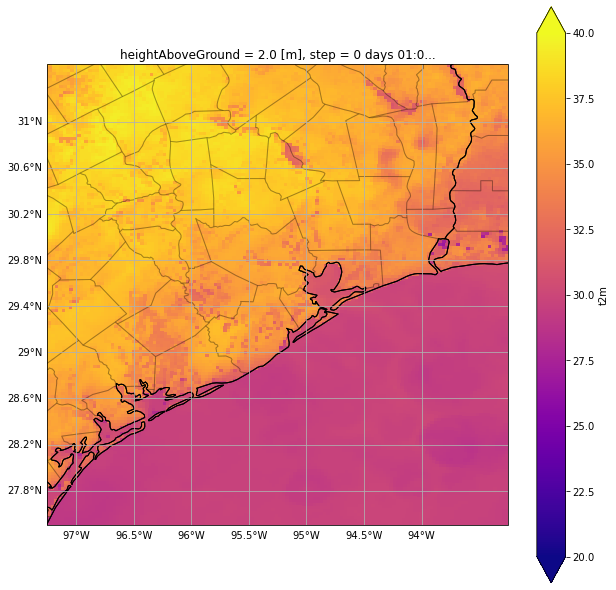

In [11]:
#Make a cartopy plot
centerlat = 29.5
centerlon = -95.25
#delta lat lon degrees
window = 2
locbox = [centerlon - window, centerlon + window, centerlat - window, centerlat + window]

#Set up the figure
myf = plt.figure(figsize=[10,10])

#We are going FULL CUSTOM.. This sets up the map panel
map_panel_axes = [0.05, 0.05, .8, .8]

#Add the map axes. Wse the Platte Carree projection. 
ax = myf.add_axes(map_panel_axes, projection=ccrs.PlateCarree())
da = ds['t2m'].isel(valid_time=0).load() - 273.15
da.plot.pcolormesh(ax=ax, transform = ccrs.PlateCarree(), 
                   x='longitude', y='latitude',
                  vmin=20, vmax=40,
                  cmap='plasma')

coast = NaturalEarthFeature(category='physical', scale='10m',
                            edgecolor='black', name='coastline')

counties = NaturalEarthFeature(category='cultural', scale='10m',
                            edgecolor='black', name='admin_2_counties_lakes', alpha=.2)

ax.add_feature(cfeature.STATES, facecolor='none', edgecolor='black')
ax.add_feature(coast, facecolor='none', edgecolor='black')
ax.add_feature(counties, facecolor='none', edgecolor='black')
  
plt.xlim(locbox[0], locbox[1])
plt.ylim(locbox[2], locbox[3])
gl = ax.gridlines(xlocs=np.linspace(-98,-94,9), ylocs=np.linspace(27.,31.,11),draw_labels=True)

gl.top_labels = False
gl.right_labels = False
gl.left_labels = True



Make a xmovie custom plot func

In [12]:
def custom_plotfunc(ds, fig, tt, *args, **kwargs):
    centerlat = 29.5
    centerlon = -95.25
    #delta lat lon degrees
    window = 2
    locbox = [centerlon - window, centerlon + window, centerlat - window, centerlat + window]

    #Set up the figure
    myf = fig

    #We are going FULL CUSTOM.. This sets up the map panel
    map_panel_axes = [0.05, 0.05, .8, .8]

    #Add the map axes. Wse the Platte Carree projection. 
    ax = myf.add_axes(map_panel_axes, projection=ccrs.PlateCarree())
    da = ds['t2m'].isel(valid_time=tt).load() - 273.15
    da.plot.pcolormesh(ax=ax, transform = ccrs.PlateCarree(), 
                       x='longitude', y='latitude',
                      vmin=20, vmax=40,
                      cmap='plasma')

    coast = NaturalEarthFeature(category='physical', scale='10m',
                                edgecolor='black', name='coastline')

    counties = NaturalEarthFeature(category='cultural', scale='10m',
                                edgecolor='black', name='admin_2_counties_lakes', alpha=.2)

    ax.add_feature(cfeature.STATES, facecolor='none', edgecolor='black')
    ax.add_feature(coast, facecolor='none', edgecolor='black')
    ax.add_feature(counties, facecolor='none', edgecolor='black')

    plt.xlim(locbox[0], locbox[1])
    plt.ylim(locbox[2], locbox[3])
    gl = ax.gridlines(xlocs=np.linspace(-98,-94,9), ylocs=np.linspace(27.,31.,11),draw_labels=True)

    gl.top_labels = False
    gl.right_labels = False
    gl.left_labels = True
    
    return None, None

(None, None)

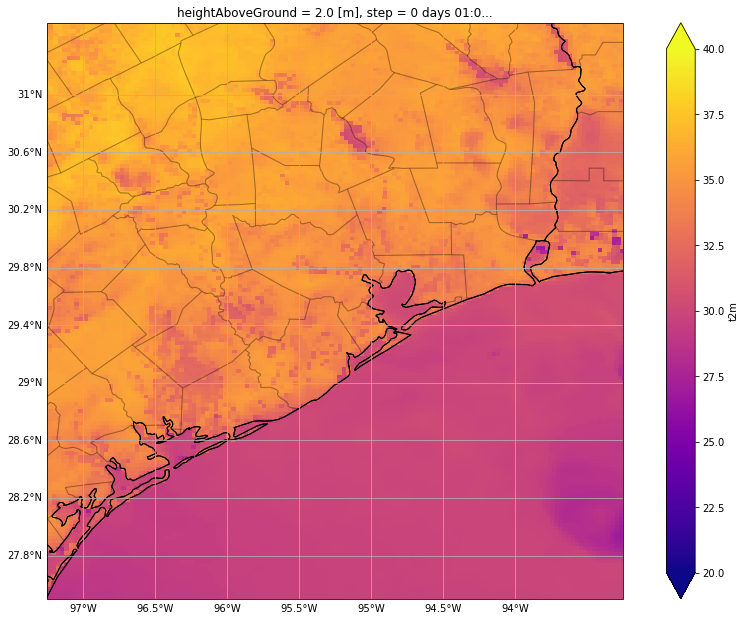

In [13]:
figme = plt.figure(figsize=[15,10])
custom_plotfunc(ds, figme, 10)

In [14]:
mov_parallel = Movie(ds,
                     custom_plotfunc, input_check=False, 
                     dpi=150, framedim='valid_time')#, dpi=300, pixelwidth=4800, pixelheight=1980,)

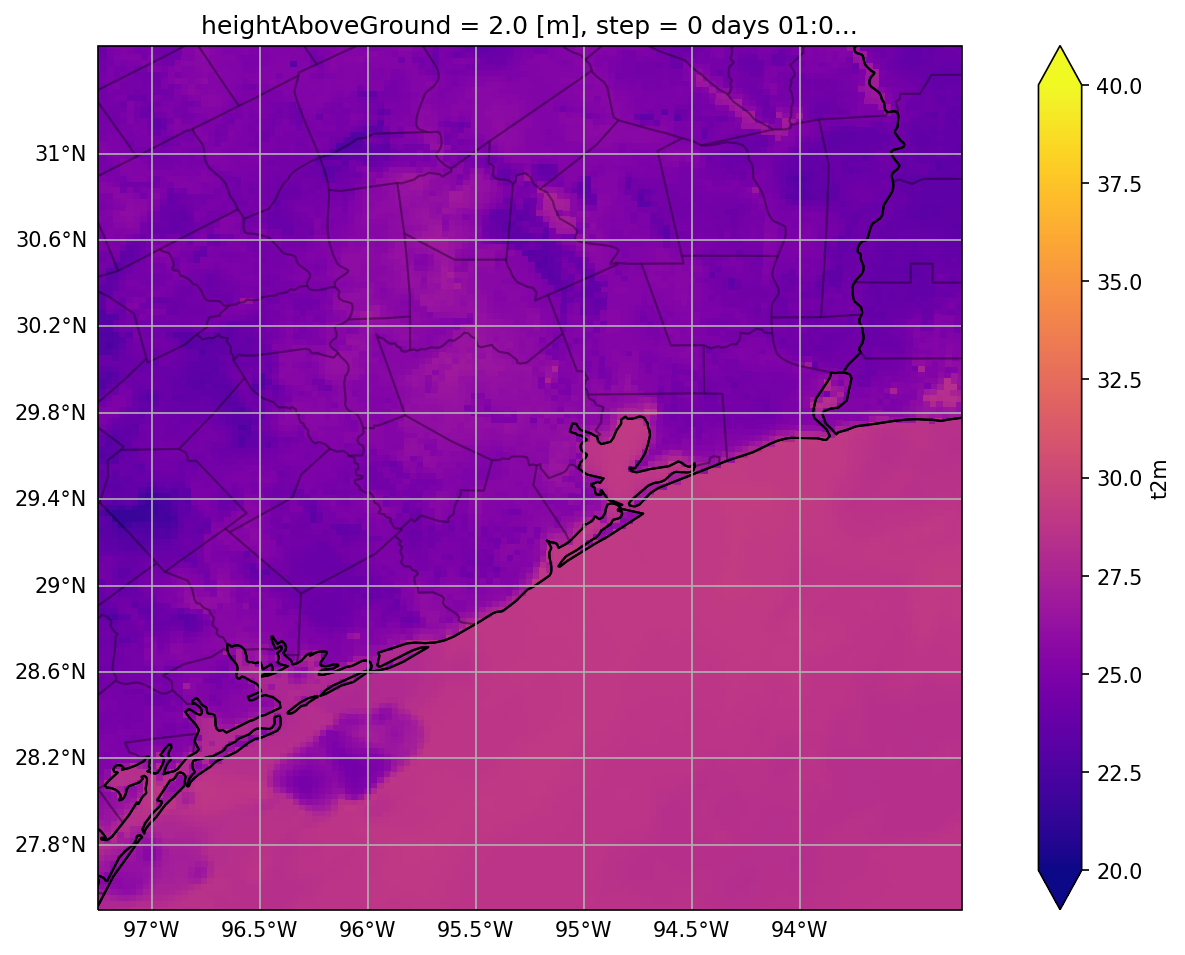

In [15]:
mov_parallel.preview(-1)

In [16]:
mov_parallel.save(
    'hrrr.mov',
    overwrite_existing=True,
    gif_resolution_factor=2.0,framerate=5
)

Movie created at hrrr.mov


In [17]:
#convert to gif

In [18]:
!ffmpeg -y -i hrrr.mov -f gif hrrr.gif

ffmpeg version 5.0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with clang version 13.0.1
  configuration: --prefix=/Users/scollis/miniconda3/envs/rsignel --cc=x86_64-apple-darwin13.4.0-clang --cxx=x86_64-apple-darwin13.4.0-clang++ --disable-doc --disable-openssl --enable-demuxer=dash --enable-gnutls --enable-hardcoded-tables --enable-libfreetype --enable-libfontconfig --enable-libopenh264 --disable-videotoolbox --enable-gpl --enable-libx264 --enable-libx265 --enable-libaom --enable-libsvtav1 --enable-libxml2 --enable-libvpx --enable-pic --enable-pthreads --enable-shared --disable-static --enable-version3 --enable-zlib --enable-libmp3lame --pkg-config=/Users/runner/miniforge3/conda-bld/ffmpeg_1657132981500/_build_env/bin/pkg-config
  libavutil      57. 17.100 / 57. 17.100
  libavcodec     59. 18.100 / 59. 18.100
  libavformat    59. 16.100 / 59. 16.100
  libavdevice    59.  4.100 / 59.  4.100
  libavfilter     8. 24.100 /  8. 24.100
  libswscale      6.  4.100 /  6.  4.100
 

<img src="hrrr.gif" width="1250" align="center">